## Extension 2 - Adding Contituent Parse Tree tags to the input 

Implementing solution described in the paper below, using text + contituent parse tree tags as features: 
"Franck Dernoncourt, Ji Young Lee, and Peter
Szolovits. 2016. Neural networks for joint sentence
classification in medical paper abstracts. European
Chapter of the Association for Computational Linguistics
(EACL) 2017."

In [1]:
import numpy as np
import pandas as pd
import os
import gc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline  

Using TensorFlow backend.


# 1 - Get Data

## 1.1 - Tokens (text)

In [2]:
# file PubMed_20k_RCT.csv created by script01_create_single_dataset
df_all_text = pd.read_csv('input/PubMed_20k_RCT.csv')
df_train_text = df_all_text[df_all_text['partition']=='train']
df_valid_text = df_all_text[df_all_text['partition']=='dev']
df_test_text = df_all_text[df_all_text['partition']=='test']
pd.set_option('max_colwidth',500)
df_all_text.head()

,partition,abstract_id,seq,text,label
0,train,4293578,0,"To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .",OBJECTIVE
1,train,4293578,1,A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .,METHODS
2,train,4293578,2,Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .,METHODS
3,train,4293578,3,Pain was assessed using the visual analog pain scale ( 0-100 mm ) .,METHODS
4,train,4293578,4,"Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .",METHODS


In [3]:
X_train_cnt = df_train_text.shape[0]
X_valid_cnt = df_valid_text.shape[0]
X_test_cnt = df_test_text.shape[0]

X_all_text = df_all_text.text.values

print('Train partition size: {}'.format(X_train_cnt))
print('Valid partition size: {}'.format(X_valid_cnt))
print('Test partition size: {}'.format(X_test_cnt))
print('Total dataset size: {}'.format(X_all_text.shape[0]))

Train partition size: 180040
Valid partition size: 30212
Test partition size: 30135
Total dataset size: 240387


## 1.2 - Contituent Parse Tree tags

In [4]:
df_all_constree = pd.read_csv('input/PubMed_20k_RCT_CONSTPARSE.csv')
df_train_constree = df_all_constree[df_all_constree['partition']=='train']
df_valid_constree = df_all_constree[df_all_constree['partition']=='dev']
df_test_constree = df_all_constree[df_all_constree['partition']=='test']
pd.set_option('max_colwidth',500)
df_all_constree.head()

,partition,abstract_id,seq,text,label,deptree,deptree2
0,train,4293578,0,"To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .",OBJECTIVE,"( ROOT ( S ( S ( VP ( TO ) ( VP ( VB ) ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( JJ ) ( JJ ) ( NN ) ) ) ) ) ) ( PP ( IN ) ( S ( VP ( VBG ) ( NP ( NP ( NN ) ) ( , ) ( NP ( NN ) ) ( , ) ( CC ) ( NP ( NP ( JJ ) ( JJ ) ( NN ) ) ( PP ( IN ) ( NP ( DT ) ( JJ ) ( NN ) ) ) ) ) ) ) ) ) ) ) ( CC ) ( S ( NP ( IN ) ( DT ) ( NN ) ) ( VP ( MD ) ( VP ( VB ) ( VP ( VBN ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( NP ( JJR ) ( NNS ) ) ( PP ( IN ...","( ROOT ( S ( S ( VP ( TO ) ( VP ( VB ) ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( JJ ) ( JJ ) ( NN ) ) ) ) ) ) ( PP ( IN ) ( S ( VP ( VBG ) ( NP ( NP ( NN ) ) ( , ) ( NP ( NN ) ) ( , ) ( CC ) ( NP ( NP ( JJ ) ( JJ ) ( NN ) ) ( PP ( IN ) ( NP ( DT ) ( JJ ) ( NN ) ) ) ) ) ) ) ) ) ) ) ( CC ) ( S ( NP ( IN ) ( DT ) ( NN ) ) ( VP ( MD ) ( VP ( VB ) ( VP ( VBN ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( NP ( JJR ) ( NNS ) ) ( PP ( IN ..."
1,train,4293578,1,A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .,METHODS,( ROOT ( S ( S ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( NN ) ( NN ) ) ) ) ) ) ( VP ( VBD ) ( VP ( VBN ) ( NP ( CD ) ) ) ) ) ( : ) ( S ( NP ( CD ) ) ( VP ( VBD ) ( SBAR ( S ( NP ( NP ( CD ) ( NN mg/day ) ) ( PP ( IN ) ( NP ( NP ( NN ) ) ( CC ) ( NP ( CD ) ) ) ) ) ( VP ( VBD ) ( NP ( NN ) ) ( PP ( IN ) ( NP ( CD ) ( NNS ) ) ) ) ) ) ) ) ( . ) ) ),( ROOT ( S ( S ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( NN ) ( NN ) ) ) ) ) ) ( VP ( VBD ) ( VP ( VBN ) ( NP ( CD ) ) ) ) ) ( ( S ( NP ( CD ) ) ( VP ( VBD ) ( SBAR ( S ( NP ( NP ( CD ) ( NN ) ( PP ( IN ) ( NP ( NP ( NN ) ) ( CC ) ( NP ( CD ) ) ) ) ) ( VP ( VBD ) ( NP ( NN ) ) ( PP ( IN ) ( NP ( CD ) ( NNS ) ) ) ) ) ) ) ) ( . ) ) )
2,train,4293578,2,Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .,METHODS,( ROOT ( S ( NP ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NN ) ( NN ) ( CC ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( NN ) ( NNS ) ) ( CC ) ( NP ( JJ ) ( NN ) ( NNS ) ) ) ) ) ( . ) ) ),( ROOT ( S ( NP ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NN ) ( NN ) ( CC ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( NN ) ( NNS ) ) ( CC ) ( NP ( JJ ) ( NN ) ( NNS ) ) ) ) ) ( . ) ) )
3,train,4293578,3,Pain was assessed using the visual analog pain scale ( 0-100 mm ) .,METHODS,( ROOT ( S ( NP ( NN ) ) ( VP ( VBD ) ( VP ( VBN ) ( S ( VP ( VBG ) ( NP ( NP ( DT ) ( JJ ) ( NN ) ( NN ) ( NN ) ) ( PRN ( -LRB- ) ( NP ( CD ) ( NN ) ) ( -RRB- ) ) ) ) ) ) ) ( . ) ) ),( ROOT ( S ( NP ( NN ) ) ( VP ( VBD ) ( VP ( VBN ) ( S ( VP ( VBG ) ( NP ( NP ( DT ) ( JJ ) ( NN ) ( NN ) ( NN ) ) ( PRN ( LRB ) ( NP ( CD ) ( NN ) ) ( RRB ) ) ) ) ) ) ) ( . ) ) )
4,train,4293578,4,"Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .",METHODS,"( ROOT ( S ( NP ( JJ ) ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NP ( NP ( DT ) ( JJ ) ( NNP ) ( CC ) ( NNP ) ( NNS ) ) ( NP ( NNP ) ( NNP ) ( NNS ) ) ) ( , ) ( NP ( NP ( NP ( NN ) ( JJ ) ( NN ) ) ( PRN ( -LRB- ) ( NP ( NN ) ) ( -RRB- ) ) ) ( PP ( IN ) ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NN ) ( NN ) ) ) ) ) ) ( , ) ( CC ) ( NP ( NP ( JJ ) ( NN ) ( NN ) ) ( PRN ( -LRB- ) ( NP ( NN ) ) ( -RRB- ) ) ) ) ) ( . ) ) )","( ROOT ( S ( NP ( JJ ) ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NP ( NP ( DT ) ( JJ

In [5]:
X_train_cnt2 = df_train_constree.shape[0]
X_valid_cnt2 = df_valid_constree.shape[0]
X_test_cnt2 = df_test_constree.shape[0]

X_all_constree = df_all_constree.deptree2.values

assert X_train_cnt2 == X_train_cnt
assert X_valid_cnt2 == X_valid_cnt
assert X_test_cnt2 == X_test_cnt
assert X_all_text.shape[0] == X_all_constree.shape[0]

# 2 - Create Vector Representation (dim=100) for Text and POS TAG Sentences

I will obtain a vectorized representation of dim = 100 of each sentence in it's text form and it's pos tag list form 

## 2.1 - Get Vector Representation for Text
### 2.1.1 - Tokenize text

In [6]:
%%time

tokenizer_text = Tokenizer()
tokenizer_text.fit_on_texts(X_all_text)
sequences_text = tokenizer_text.texts_to_sequences(X_all_text)

word_index_text = tokenizer_text.word_index
VOC_SIZE_text = len(word_index_text)
print('Vocabulary size = {}'.format(VOC_SIZE_text))

Vocabulary size = 67356
CPU times: user 22.7 s, sys: 311 ms, total: 23 s
Wall time: 37.3 s


In [7]:
MAX_SEQ_LEN_text = 50
X_seq_all_text = pad_sequences(sequences_text, maxlen=MAX_SEQ_LEN_text, dtype='int32', \
                               padding='pre', truncating='post', value=0)
print(X_seq_all_text.shape)

(240387, 50)


### 2.1.2 Get vector represetation of sentence text using LSMT MLP model

#### 2.1.2.1 Retrieve pre-trained LSMT MLP model

In [8]:
%%time

# read model that creates vector representation of sentences

from keras.models import load_model

model_text = load_model('input/Baseline_Part1_LSTM_MPL.h5')

model_text.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 50, 200)           13471400  
_________________________________________________________________
lstm_4 (LSTM)                (None, 800)               3203200   
_________________________________________________________________
sentence_vector_1 (Dense)    (None, 100)               80100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
sentence_vector_2 (Dense)    (None, 20)                2020      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
__________

#### 2.1.2.2 Get vector with dim = 100 representing sentence text

In [9]:
%%time

# get tensor representation of sentences as output from layer "sentence_vector_2"

from keras.models import Model

layer_name = 'sentence_vector_1'
intermediate_layer_model = Model(inputs=model_text.input, outputs=model_text.get_layer(layer_name).output)

# get tensor representation of training partition
sentence_train_text = intermediate_layer_model.predict(X_seq_all_text[:X_train_cnt])

# get tensor representation of validation partition
sentence_valid_text = intermediate_layer_model.predict(X_seq_all_text[X_train_cnt:(X_train_cnt+X_valid_cnt)])

# get tensor representation of test partition
sentence_test_text = intermediate_layer_model.predict(X_seq_all_text[-X_test_cnt:])

# concat all data
sentence_all_text = np.vstack((sentence_train_text, sentence_valid_text, sentence_test_text))

print(sentence_train_text.shape)
print(sentence_valid_text.shape)
print(sentence_test_text.shape)
print(sentence_all_text.shape)

(180040, 100)
(30212, 100)
(30135, 100)
(240387, 100)
CPU times: user 2h 32min 45s, sys: 3min 22s, total: 2h 36min 8s
Wall time: 48min 21s


## 2.2 - Get Vector Representation for Constituent Tree
### 2.2.1 - Tokenize Constituent Tree tags

In [10]:
%%time

from collections import Counter

# will only use 50 most common tokens

all_text = ' '.join(X_all_constree)
all_tokens = [token for token in all_text.split()]
top_tokens = Counter(all_tokens).most_common(50)
i = 0
word_index = {k:i+1 for i, (k, _) in enumerate(top_tokens)}

VOC_SIZE_constree = len(word_index)
print('Vocabulary size = {}'.format(VOC_SIZE_constree))

sequences_constree = [[word_index[token] for token in parsetree.split() if word_index.get(token,-1)!=-1] \
                      for parsetree in X_all_constree]

Vocabulary size = 50
CPU times: user 32.3 s, sys: 2.44 s, total: 34.7 s
Wall time: 53 s


In [11]:
MAX_SEQ_LEN_constree = 300
X_seq_all_constree = pad_sequences(sequences_constree, maxlen=MAX_SEQ_LEN_constree, dtype='int32', \
                               padding='pre', truncating='post', value=0)
print(X_seq_all_constree.shape)

(240387, 300)


### 2.2.2 - One hot encode Constituent Tree

In [12]:
X_seq_all_constree

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ..., 
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]], dtype=int32)

In [13]:
%%time

EMBEDDING_DIM_constree = VOC_SIZE_constree

def get_vector(token):
    vector = np.zeros(EMBEDDING_DIM_constree)
    if token != 0:
        vector[token-1] = 1
    return vector

X_seq_all_constree_v = np.zeros((X_seq_all_constree.shape[0], X_seq_all_constree.shape[1] * EMBEDDING_DIM_constree))
print(X_seq_all_constree_v.shape)
i = 0
for token_seq in X_seq_all_constree:
    X_seq_all_constree_v[i] = np.array([get_vector(token) for token in token_seq]).flatten()
    i += 1

X_seq_all_constree_v = X_seq_all_constree_v.reshape(X_seq_all_constree_v.shape[0], \
                                               int(X_seq_all_constree_v.shape[1]/EMBEDDING_DIM_constree), \
                                               EMBEDDING_DIM_constree)
print(X_seq_all_constree_v.shape)

(240387, 15000)
(240387, 300, 50)
CPU times: user 13min 3s, sys: 24.9 s, total: 13min 28s
Wall time: 21min 48s


### 2.2.3 Get vector represetation of Constituent Tree text using pre-trained ConvD1 model

#### 2.2.3.1 Retrieve pre-trained Constituent Tree model

In [14]:
%%time

# read model that creates vector representation of sentences

from keras.models import load_model

model_constree = load_model('input/Extension_Part1_CONV1_CONSTPARSE1.h5')

model_constree.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300, 50)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 296, 64)           16064     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 292, 64)           20544     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 58, 64)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 54, 128)           41088     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 50, 128)           82048     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
__________

#### 2.2.3.2 Get vector with dim = 100 representing sentence POS TAG sequence

In [15]:
%%time

# get tensor representation of sentences as output from layer "sentence_vector_2"

layer_name = 'sentence_vector_1'
intermediate_layer_model = Model(inputs=model_constree.input, outputs=model_constree.get_layer(layer_name).output)

# get tensor representation of training partition
sentence_train_constree = intermediate_layer_model.predict(X_seq_all_constree_v[:X_train_cnt])

# get tensor representation of validation partition
sentence_valid_constree = intermediate_layer_model.predict(X_seq_all_constree_v[X_train_cnt:(X_train_cnt+X_valid_cnt)])

# get tensor representation of test partition
sentence_test_constree = intermediate_layer_model.predict(X_seq_all_constree_v[-X_test_cnt:])

# concat all data
sentence_all_constree = np.vstack((sentence_train_constree, sentence_valid_constree, sentence_test_constree))

print(sentence_train_constree.shape)
print(sentence_valid_constree.shape)
print(sentence_test_constree.shape)
print(sentence_all_constree.shape)

(180040, 100)
(30212, 100)
(30135, 100)
(240387, 100)
CPU times: user 16min 47s, sys: 1min 44s, total: 18min 31s
Wall time: 6min 59s


## 3 - Vectorize output labels

In [16]:
%%time

labels = df_all_text.label.values
label_dict = {label: no for no, label in enumerate(set(labels))}
number_of_classes = len(label_dict)

# get labels as integers
y_all = [label_dict[label] for label in labels]

# change y to categorical (vectorize output)
y_all = np.array([to_categorical(i, num_classes=number_of_classes) for i in y_all])

print(y_all.shape)

(240387, 5)
CPU times: user 5.05 s, sys: 783 ms, total: 5.84 s
Wall time: 9.24 s


## 4 - Combine Text and Constituent Tree representations

In [17]:
X_train_comb = np.hstack((sentence_train_text, sentence_train_constree))
X_valid_comb = np.hstack((sentence_valid_text, sentence_valid_constree))
X_test_comb = np.hstack((sentence_test_text, sentence_test_constree))
print(X_train_comb.shape)
print(X_valid_comb.shape)
print(X_test_comb.shape)

(180040, 200)
(30212, 200)
(30135, 200)


## 5 - Train combined model (text and Constituent)

In [18]:
%%time

from keras.layers import Embedding, Input, LSTM, Flatten, Dropout, Dense, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping
from keras import regularizers

comb = Input(shape=(200,), dtype='float32')
D1 = Dense(units=200, activation='relu')(comb)
D1 = Dropout(0.5)(D1)
D1 = Dense(units=100, activation='relu', name='sentence_vector_1')(D1)
D1 = Dropout(0.5)(D1)
D1 = Dense(units=20, activation='relu')(D1)
D1 = Dropout(0.5)(D1)
out = Dense(5,
            kernel_regularizer=regularizers.l2(0.01),
            activity_regularizer=regularizers.l1(0.01),
            activation="softmax")(D1) 

model = Model(comb, out)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

# learn
model.fit(X_train_comb, y_all[:X_train_cnt], \
          validation_data=(X_valid_comb, y_all[X_train_cnt:(X_train_cnt+X_valid_cnt)]), \
          callbacks=[EarlyStopping(patience=1, monitor='val_loss')], \
          verbose=1, epochs=20, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
sentence_vector_1 (Dense)    (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
__________

## 6 - Save combined model

In [19]:
model.save('input/Extension_Part1_LSTM_MLP_Glove_CONV1_constree.h5')

## 7 - Create sentence and label sequences

### 7.1 - Find max length of sequences

Total number of abstracts = 20000
Max abstract size = 31


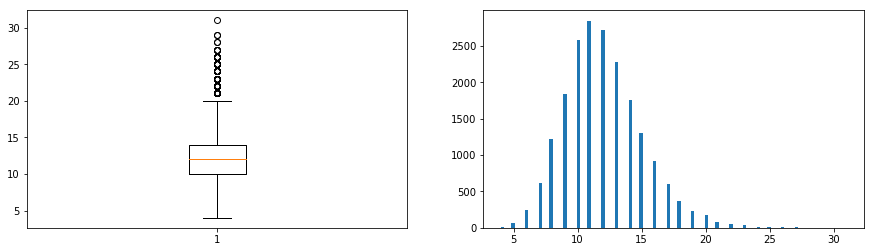

In [20]:
# find size of abstracts

# create dataframe with abstract lengths
abstract_lens = df_all_text[['abstract_id','text']].groupby(by='abstract_id').agg('count')

# create dict with abstract lengths
abstract_len_dict = {abstract_id: length for abstract_id, length in abstract_lens.reset_index().values}

print('Total number of abstracts = {}'.format(len(abstract_lens.index)))
print('Max abstract size = {}'.format(np.max(abstract_lens.text.values)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].boxplot(abstract_lens.text.values)
axes[1].hist(abstract_lens.text.values, bins=100)
plt.show()

### 7.2 - Redo vectorization of output labels - add 'PAD'

In [21]:
%%time

y_labels = df_all_text.label.values

# create label set and add 'PAD' to the set
label_set = set(y_labels)
label_set.add('PAD')
label_dict = {label: no for no, label in enumerate(label_set)}
number_of_classes = len(label_dict)

# get inverted dict
label_dict_inv = {no: label for label, no in label_dict.items()}

# get labels as integers
y_all = [label_dict[label] for label in y_labels]

# change y to categorical (vectorize output)
y_all = np.array([to_categorical(i, num_classes=number_of_classes) for i in y_all])

print(y_all.shape)

(240387, 6)
CPU times: user 4.43 s, sys: 92.7 ms, total: 4.52 s
Wall time: 6.08 s


### 7.3 - Get vectorized representation of sentence text + POS tags

In [22]:
%%time

# get tensor representation of sentences as output from layer "sentence_vector_2"

layer_name = 'sentence_vector_1'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# get tensor representation of training partition
sentence_train = intermediate_layer_model.predict(X_train_comb)

# get tensor representation of validation partition
sentence_valid = intermediate_layer_model.predict(X_valid_comb)

# get tensor representation of test partition
sentence_test = intermediate_layer_model.predict(X_test_comb)

# concat all data
sentence_all = np.vstack((sentence_train, sentence_valid, sentence_test))

print(sentence_train.shape)
print(sentence_valid.shape)
print(sentence_test.shape)
print(sentence_all.shape)

(180040, 100)
(30212, 100)
(30135, 100)
(240387, 100)
CPU times: user 12.4 s, sys: 1.43 s, total: 13.8 s
Wall time: 10.8 s


### 7.4 - Create sequences

In [23]:
%%time

# Get abstract and label sequences

def get_abstract_seq(sentence_arry, i, j):
    # create flattened array with sentences for this abstract
    sentences = sentence_arry[i:j].flatten()
    # create enough zero padding to reach 31 sentences, the max no of sentences for abstract in dataset
    left_padding  = np.zeros(100 * (31 - (j - i)))
    # pad left
    full_abstract = np.hstack((left_padding, sentences))
    # abstract must be 31 sentences long, and each sentence has len 100
    assert len(full_abstract) == 3100
    return full_abstract

def get_label_seq(label_arry, pad, i, j):
    # create flattened array with sentences for this abstract
    labels = label_arry[i:j].flatten()
    # create enough zero padding to reach 31 sentences, the max no of sentences for abstract in dataset
    left_padding  = np.array(list(pad) * (31 - (j - i)))
    # pad left
    full_labels = np.hstack((left_padding, labels))
    # abstract must be 31 sentences long, and each sentence has len 100
    assert len(full_labels) == 31 * 6
    return full_labels

# create lists to store abstracts and label sequence for abstracts
abstracts = list()
labels = list()
sorted_abs_id = list()

# find categorial 
y_PAD = to_categorical(label_dict['PAD'], num_classes=number_of_classes)

i = 0
while True:
    
    # find number of sentences in abstract
    abs_id = df_all_text.abstract_id.values[i]
    # save district abstract ids, in the order they appear in the dataset
    sorted_abs_id.append(abs_id)
    abs_len = abstract_len_dict[abs_id]
    j = i + abs_len
    
    # get flattened sentences that make up abstract
    abstracts.append(get_abstract_seq(sentence_all, i, j))
    
    # get flattened labels that make up abstract labels
    labels.append(get_label_seq(y_all, y_PAD, i, j))
    
    i = j
    if j >= len(df_all_text.index):
        print('Done!')
        break
        
print('Number of abstracts: {}'.format(len(abstracts)))
print('Number of label seqs: {}'.format(len(labels)))

print('\nNumber of abstracts in each partition: \n{}'.format(df_all_text.groupby(by=('partition')).abstract_id.nunique()))

Done!
Number of abstracts: 20000
Number of label seqs: 20000

Number of abstracts in each partition: 
partition
dev       2500
test      2500
train    15000
Name: abstract_id, dtype: int64
CPU times: user 2.38 s, sys: 361 ms, total: 2.74 s
Wall time: 3.75 s


In [24]:
# restore partition data

X_all = np.array(abstracts)
X_all = X_all.reshape(X_all.shape[0],31,100)
X_train = X_all[:15000]
X_valid = X_all[15000:17500]
X_test  = X_all[-2500:]

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

y_seq_all = np.array(labels)
y_seq_all = y_seq_all.reshape(y_seq_all.shape[0],31,6)
y_seq_train = y_seq_all[:15000]
y_seq_valid = y_seq_all[15000:17500]
y_seq_test  = y_seq_all[-2500:]

print(y_seq_train.shape)
print(y_seq_valid.shape)
print(y_seq_test.shape)

(15000, 31, 100)
(2500, 31, 100)
(2500, 31, 100)
(15000, 31, 6)
(2500, 31, 6)
(2500, 31, 6)


# 8 - Train final model

In [25]:
%%time

from keras.layers import Embedding, Input, LSTM, Flatten, Dropout, Dense, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping

abs = Input(shape=(X_all.shape[1], X_all.shape[2]), dtype='float32')
lstm = Bidirectional(LSTM(units=100, return_sequences=True))(abs)
out = TimeDistributed(Dense(6, activation="softmax"))(lstm) 

model_final = Model(abs, out)
model_final.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model_final.summary()

# learn
model_final.fit(X_train, y_seq_train, validation_data=(X_valid, y_seq_valid), \
            callbacks=[EarlyStopping(patience=1, monitor='val_loss')], \
            verbose=1, epochs=20, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 31, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 31, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 31, 6)             1206      
Total params: 162,006
Trainable params: 162,006
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 2500 samples
Epoch 1/20
15000/15000 [==============================] - 33s 2ms/step - loss: 0.1293 - acc: 0.9639 - val_loss: 0.1034 - val_acc: 0.9625
Epoch 2/20
15000/15000 [==============================] - 25s 2ms/step - loss: 0.0749 - acc: 0.9703 - val_loss: 0.0983 - val_acc: 0.9631
Epoch 3/20
15000/15000 [==============================] - 24s 2ms/step - loss

## 9 - Save final model

In [26]:
model_final.save('input/Extension_final_2.h5')

## 10 - Final prediction on test dataset

In [27]:
from sklearn.metrics import accuracy_score

preds = model_final.predict(X_test)
y_seq_hat = np.argmax(preds, axis=-1).flatten()

y_seq_true = np.argmax(y_seq_test, axis=-1).flatten()

acc = accuracy_score(y_seq_true, y_seq_hat)
print('Accuracy on test partition (padded label sequence): {}'.format(acc))

Accuracy on test partition (padded label sequence): 0.9635225806451613


In [28]:
preds = model_final.predict(X_test)
y_seq_hat = np.argmax(preds, axis=-1)
y_seq_true = np.argmax(y_seq_test, axis=-1)

#print(y_seq_hat.shape)
#print(y_seq_true.shape)

y_seq_hat_trimmed = list()
y_seq_true_trimmed = list()
i = 0
for abs_id in sorted_abs_id[-2500:]:
    x = list(y_seq_hat[i][-abstract_len_dict[abs_id]:])
    while len(x) > 0:
        y_seq_hat_trimmed.insert(0, x.pop())
    x = list(y_seq_true[i][-abstract_len_dict[abs_id]:])
    while len(x) > 0:
        y_seq_true_trimmed.insert(0, x.pop())    
    i += 1
    
#print(len(y_seq_hat_trimmed))
#print(len(y_seq_true_trimmed))

acc = accuracy_score(y_seq_true_trimmed, y_seq_hat_trimmed)
print('Accuracy on test partition (no padding): {}'.format(acc))

Accuracy on test partition (no padding): 0.9061888169902107


In [31]:
from sklearn.metrics import f1_score

f1_score(y_seq_true_trimmed, y_seq_hat_trimmed, average='micro')

0.9061888169902107